## ONNX - первый опыт

ONNX — это гибкий открытый стандартный формат для представления моделей. Позволяющий запускать модели на разном железе и разной среде выполнения.



В этом семинаре мы разберем:

1. Экспортируйт модели в формат ONNX.
2. Сохранение модели ONNX в файл.
3. Визуализация модели ONNX, используя
 [Нетрон](https://github.com/lutzroeder/netron).
4. Выполнение модели ONNX с помощью [ONNX Runtime]{.title-ref}
5. Сравнение результатов PyTorch.


<br>

=================================== <br>

Необходимые зависимости:

> ``` {.sourceCode .bash}
> pip install onnx
> pip install onnxscript
> ```


In [1]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        
        if x.sum() > 0:
            x = torch.flatten(x, 1)
            
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Экспортируем модель в формат ONNX. 


Cюрприз сюрприз! <br>

Мы используем тут ``torch.jit.trace``, соотвественно, все проблемы которые мы обсуждали тут появятся. 



In [2]:
torch_model = MyModel()
torch_input = torch.randn(1, 1, 32, 32)
torch.onnx.export(torch_model,torch_input, 'model.onnx')


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/tmp/ipykernel_74230/500133859.py:23: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.sum() > 0:


In [3]:
class MyModel(nn.Module):

    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
torch_model = MyModel()
torch_input = torch.randn(1, 1, 32, 32)

torch.onnx.export(torch_model,
                torch_input, 
                'model.onnx', 
                do_constant_folding=True,
                input_names = ['input'],   # the model's input names
                output_names = ['output'])

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Ок, во втором случае у нас не было никаих ошибок.  <br>


Так же есть и другой способ конвертации, но он еще свежий и иногда бывают ошибки с зависимостями. <br>

``onnx_program = torch.onnx.dynamo_export(model, tensor_x)``

In [5]:
import onnx
onnx_model = onnx.load('model.onnx')
onnx.checker.check_model(onnx_model)

In [6]:
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch_jit (
  %input[FLOAT, 1x1x32x32]
) initializers (
  %conv1.weight[FLOAT, 6x1x5x5]
  %conv1.bias[FLOAT, 6]
  %conv2.weight[FLOAT, 16x6x5x5]
  %conv2.bias[FLOAT, 16]
  %fc1.weight[FLOAT, 120x400]
  %fc1.bias[FLOAT, 120]
  %fc2.weight[FLOAT, 84x120]
  %fc2.bias[FLOAT, 84]
  %fc3.weight[FLOAT, 10x84]
  %fc3.bias[FLOAT, 10]
) {
  %/conv1/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%input, %conv1.weight, %conv1.bias)
  %/Relu_output_0 = Relu(%/conv1/Conv_output_0)
  %/MaxPool_output_0 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%/Relu_output_0)
  %/conv2/Conv_output_0 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%/MaxPool_output_0, %conv2.weight, %conv2.bias)
  %/Relu_1_output_0 = Relu(%/conv2/Conv_output_0)
  %/MaxPool_1_output_0 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]

Визуализируем график модели ONNX с помощью Netron

Теперь, когда наша модель сохранена в файле, мы можем визуализировать ее с помощью
[Netron](https://github.com/lutzroeder/netron). Netron может быть либо
устанавливается на компьютеры Macos, Linux или Windows или запускается непосредственно из
браузер. Давайте попробуем веб-версию, открыв следующую ссылку:
<https://netron.app/>.

![image](https://pytorch.org/tutorials/_static/img/onnx/netron_web_ui.png){.align-center
width="70.0%"}

Как только Netron откроется, мы можем перетащить наш `my_image_classifier.onnx`
файл в браузере или выберите его, нажав кнопку **Открыть модель**.
кнопка.

![image](https://pytorch.org/tutorials/_static/img/onnx/image_clossifier_onnx_modelon_netron_web_ui.png){width="50.0%"}

И это все! Мы успешно экспортировали нашу модель PyTorch в ONNX.
формате и визуализировал его с помощью Netron.



Запуск модели ONNX с помощью ONNX Runtime.
===========================================


> ``` {.sourceCode .bash}
> pip install onnxruntime
> ```

Стандарт ONNX не поддерживает все структуры и типы данных, которые есть в
PyTorch, поэтому часто нам нужно адаптировать входные данные PyTorch к формату ONNX, прежде чем
передать его в среду выполнения ONNX.  <br>

ONNX Runtime требует дополнительного шага, который включает в себя преобразование всех
Тензоры PyTorch в Numpy (на CPU) и оборачивание их в словарь, ключи представляют собой строку с входным именем в качестве ключа и тензором numpy в качестве
значения. <br>

Теперь мы можем создать *сеанс вывода времени выполнения ONNX*, выполнить команду ONNX.
модель с обработанными входными данными и получить выходные данные. В этом семинаре
ONNX Runtime выполняется на CPU, но его можно запустить и на GPU. <br>

In [7]:
import onnxruntime

options = onnxruntime.SessionOptions()
options.intra_op_num_threads = 10

#onnx_input = onnx_model.adapt_torch_inputs_to_onnx(torch_input)

print(f"Input length: {len(torch_input)}")


ort_session = onnxruntime.InferenceSession("./model.onnx",sess_options=options, providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch_input)}



start_time = time.time()
for _ in range(1000):        
    #execution_time = end_time - start_time
    onnxruntime_outputs = ort_session.run(None, ort_inputs)
end_time = time.time()
execution_time = end_time - start_time
print(f'elapsed in {execution_time}')
# Calculate the execution time

Input length: 1
elapsed in 0.08559751510620117


Сравним результаты PyTorch с результатами среды выполнения ONNX.


In [8]:
start_time = time.time()
for _ in range(1000):        
    #execution_time = end_time - start_time
    torch_outputs = torch_model(torch_input)
end_time = time.time()
execution_time = end_time - start_time
print(f'elapsed in {execution_time}')

elapsed in 11.248764991760254


In [9]:
assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output)[0])

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [array([[ 0.06829299,  0.03038987,  0.03878107,  0.06286454, -0.0067445 ,
         0.07527031, -0.0471851 ,  0.10588882,  0.10084195, -0.06539278]],
      dtype=float32)]


А теперь одна из многих возможностей ONNX, это конвертация модели в fp16

In [10]:
# pip install onnx onnxconverter-common
from onnxconverter_common import float16
 
model_fp16 = float16.convert_float_to_float16(onnx_model)
onnx.save(model_fp16, "model_fp16.onnx")

In [11]:
ort_session = onnxruntime.InferenceSession("./model_fp16.onnx",sess_options=options, providers=['CPUExecutionProvider'])

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch_input).astype(np.float16)}



start_time = time.time()
for _ in range(1000):        
    #execution_time = end_time - start_time
    onnxruntime_outputs = ort_session.run(None, ort_inputs)
end_time = time.time()
execution_time = end_time - start_time
print(f'elapses in {execution_time}')
# Calculate the execution time

elapses in 0.2501657009124756


In [12]:
torch_outputs = torch_model(torch_input)


assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output.to(torch.float16), torch.tensor(onnxruntime_output)[0])

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")

PyTorch and ONNX Runtime output matched!
Output length: 1
Sample output: [array([[ 0.06824,  0.03038,  0.0388 ,  0.06287, -0.00676,  0.07526,
        -0.04718,  0.10583,  0.1009 , -0.0654 ]], dtype=float16)]


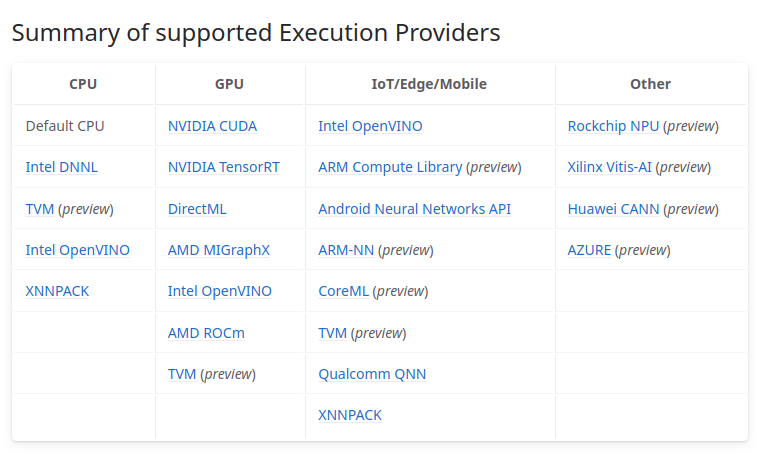

In [13]:
 #set providers to ['TensorrtExecutionProvider', 'CUDAExecutionProvider'] with TensorrtExecutionProvider having the higher priority.

ort_session = onnxruntime.InferenceSession("./model.onnx",sess_options=options, providers=['TensorrtExecutionProvider'])

ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(torch_input)}



start_time = time.time()
for _ in range(1000):        
    #execution_time = end_time - start_time
    onnxruntime_outputs = ort_session.run(None, ort_inputs)
end_time = time.time()
execution_time = end_time - start_time
print(f'elapses in {execution_time}')
# Calculate the execution time

elapses in 0.09225773811340332


/usr/local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'TensorrtExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
